In [1]:
#
# phase1:
#   Gaussian Mixture Model (GMM) distribution approximating
#   normalising flow & mean field
#

%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import network.meanField as mf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
floatX = utils.floatX

In [11]:
PRENUM = 50000
NUM_LAYERS = 32
DIM = 2
SAMPLINGNUM = 30
NUMITER = 5000

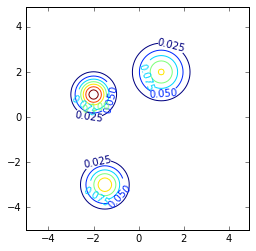

In [21]:
# true p(z)
means   = np.asarray( [[1.0,2.0],[-1.5,-3],[-2.0,1.0]] )
varmats = np.asarray( [np.eye(2)/2, np.eye(2)/3, np.eye(2)/4] ) 
weights = np.asarray( [0.4,0.3,0.3] )

logTarget = mathT.multiGmm(means, varmats,weights)

# true p(z)
fgmm = mathZ.multiGmmInit(means,varmats,weights)
showvalues = []
gz, g1, g2 = mathZ.gridPoints( (-5,5,0.1), (-5,5,0.1) )
gpz = np.exp( fgmm(gz).reshape(g1.shape[1],g2.shape[0]) )
fig = plt.figure()
CS = plt.contour(g1,g2,gpz)
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.show()

In [22]:
# construction variational model
vi = mf.MeanField(DIM)
zs, logqzs = vi.getZ(SAMPLINGNUM)

# setting cost variable
logpzs = logTarget(zs)
cost = T.mean( logqzs - logpzs ) # KL cost

params = vi.getParams()
grads = [ T.grad(cost,p) for p in params ]

In [23]:
# optimisation setup
# iaf.reInit()
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpzs), T.mean(logqzs) ]
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [24]:
# training
keys = ['cost','pz','qz']
record = {'zs':[]}

for k in keys:
    record[k] = []

for i in range(NUMITER):
    out = estep()
    for k,q in enumerate(out):
        record[keys[k]].append( q )
        
for k in keys:
    record[k] = np.asarray( record[k] )

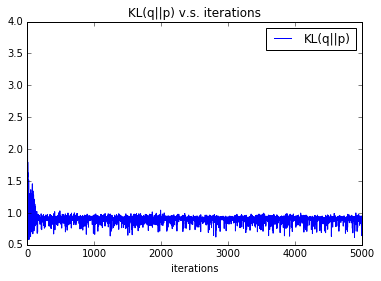

In [25]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)

plt.xlabel('iterations')
plt.title('KL(q||p) v.s. iterations')
plt.plot( xs, record['cost'], '-', label='KL(q||p)')
# plt.plot( xs, record['pz'], '-', label='log-pz')
# plt.plot( xs, record['qz'], '-', label='log-qz')

plt.legend()

# plt.plot( xs, record['mu'][:,0], '-', label='mean-z0')
# plt.plot( xs, record['mu'][:,1], '-', label='mean-z1')
# plt.legend()
# plt.show()

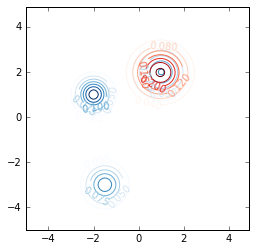

In [35]:
# true p(z)
fgmm = mathZ.multiGmmInit(means,varmats,weights)
showvalues = []
gz, g1, g2 = mathZ.gridPoints( (-5,5,0.1), (-5,5,0.1) )
gpz = np.exp( fgmm(gz).reshape(g1.shape[1],g2.shape[0]) )
fig = plt.figure()
CS = plt.contour(g1,g2,gpz,cmap='Blues')
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')


# true q(z)
gz, g1, g2 = mathZ.gridPoints( (-5,5,0.1), (-5,5,0.1) )
mflogqz = vi.nlogqz(gz,renew=True)
gpz = np.exp( mflogqz.reshape(g1.shape[1],g2.shape[0]) )
CS = plt.contour(g1,g2,gpz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.show()